# SOM


In [568]:
import numpy as np

class Neuron:
    def __init__(self, x, y, length):
        self.x = x
        self.y = y
        self.length = length
        self.nf = 100.
        self.w = [np.random.uniform(-1,10) for i in range(self.length)]
        self.lr = 0.1
        self.decay = 0.00001
        
    def distance(self, example):
        return np.sqrt(np.sum((self.w-example)**2))        
        
    def gauss(self, win, it):
        r2 = (win.x-self.x)**2+(win.y-self.y)**2
        sigma = 1 #self.gain(it)
        A = 1/(2.0*np.pi*sigma**2)
        g = A*np.exp(-r2/(2.0*sigma**2))
        return g
    
    def gain(self, it):
        return np.exp(-it/self.nf)
        
    def learningRate(self, it):
        self.lr -= self.decay
        self.lr = max([0.001, self.lr])
        #return 0.001*np.exp(-it/100.0)
        return self.lr
                       
    def update(self, example, win, it):      
        lr = self.learningRate(it)
        gg = self.gauss(win, it)        
        
        dw = np.zeros(2)
        #if(self.x == win.x and self.y == win.y):
        dw = lr*gg*(example-win.w)
        self.w += dw
        return np.sum(dw**2)


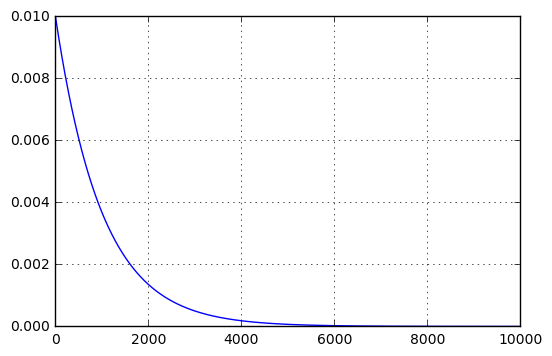

In [569]:
n = Neuron(0, 1, 2)
x = np.arange(0, 10000)
y = 0.01*np.exp(-x/1000.)

import math
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, y, c='b')

plt.grid(True)

In [570]:
class SOM:
    def __init__(self, dim, length):
        self.dim = dim
        self.length = length
        #self.neurons = [[Neuron(i,j, self.length) for j in range(self.dim)] for i in range(self.dim)]        
        self.neurons = []
        for i in range(self.dim):
            el = []
            for j in range(self.dim):
                neuron = Neuron(i, j, self.length)
                el.append(neuron)
            self.neurons.append(el)        
    
    def model(self):
        ret = []
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                ret.append(np.array(neuron.w))
        return np.array(ret)
        
    
    def debug(self):
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                print i, j, neuron.w
        
    def winner(self, example):
        retVal = self.neurons[0][0]
        _min = retVal.distance(example)
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                d = neuron.distance(example)
                if d<_min:
                    _min = d
                    retVal = neuron
        return retVal
    
    def update(self, example, it):
        error = 0
        winner = self.winner(example)
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                error += neuron.update(example, winner, it)
        return error/float(self.dim**2)
                        
    
    def fit(self, examples):
        ret = []
        maxerr = 0.00001
        blok = 100
        for it in range(1000):
            err = 0
            n = 10
            for i in range(n):
                el = random.choice(examples)
                err += self.update(el, it)
            err = err/float(n)
            #if err<maxerr:
            #    print '---- obucen -----'+str(it)+'  '+str(err)
            #    break
            #print '---- err -----'+str(it)+'  '+str(err)
            ret.append(self.model())
        return np.array(ret)


In [583]:
import random

_examples = [[0,0], [15,15], [0,10], [10,0]]
examples = []

for el in _examples:
    for r in range(40):
        da = random.uniform(-2, 2)
        db = random.uniform(-2, 2)
        examples.append([el[0]+da, el[1]+db])

examples = np.array(examples)

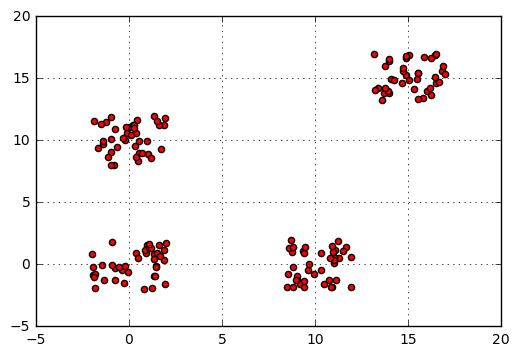

In [584]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(examples[:,0], examples[:,1], c='r')

plt.grid(True)


In [593]:
som = SOM(2, 2)

In [594]:
tr = som.fit(examples)

In [595]:
som.debug()

model = som.model()

print tr.shape

0 0 [  0.14143627  10.23500554]
0 1 [ 9.93696921 -0.10012471]
1 0 [ 14.96218317  15.26419257]
1 1 [ 0.3301416   0.08866057]
(1000, 4, 2)


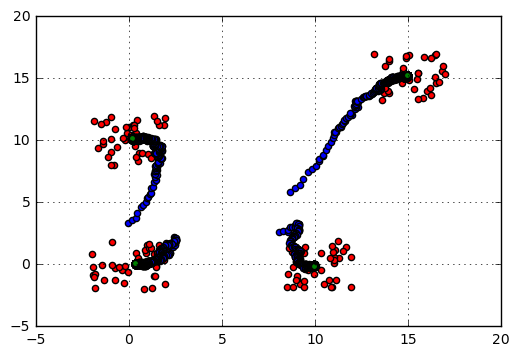

In [596]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(examples[:,0], examples[:,1], c='r')
plt.scatter(tr[:,0,0], tr[:,0,1], c='b')
plt.scatter(tr[:,1,0], tr[:,1,1], c='b')
plt.scatter(tr[:,2,0], tr[:,2,1], c='b')
plt.scatter(tr[:,3,0], tr[:,3,1], c='b')
plt.scatter(model[:,0], model[:,1], c='g')

plt.grid(True)